## Power Spectrum based on OLR

### Import package

In [1]:
import numpy as np;
import netCDF4 as nc;

from scipy.ndimage import convolve1d;
from matplotlib import pyplot as plt;

### Load file

In [2]:
fpath = "/work/DATA/Satellite/OLR/olr_anomaly.nc";

with nc.Dataset( fpath, "r" ) as ds:
    dims = {
        key: ds[key][:]
        for key in ds.dimensions.keys()
    };
    
    lat_lim = np.where( ( dims["lat"] >= -5.0 ) & ( dims["lat"] <= 5.0 ) )[0];
    dims["lat"]  = dims["lat"][lat_lim];
    dims["time"] = dims["time"][:1000];
    
    olr = ds["olr"][:1000, lat_lim, :];

### Processing data

#### Form symmetric and asymmetric data

In [3]:
olr -= olr.mean( axis=(0, 2), keepdims=True )

sym = ( olr + np.flip( olr, axis=1 ) ) / 2;
asy = ( olr - np.flip( olr, axis=1 ) ) / 2;

#### windowing data

In [4]:
hanning = np.hanning( 96 )[:, None, None];

sym_window = [];
asy_window = [];

for i in range( 1000 // 96 ):
    sym_window.append( sym[i*48:i*48+96] * hanning );
    asy_window.append( asy[i*48:i*48+96] * hanning );
    
sym_window = np.array( sym_window );
asy_window = np.array( asy_window );

print( sym_window.shape )

(10, 96, 20, 576)


### Compute power spectrum

#### Compute power spectrum

In [5]:
def power_spec( data ):
    
    data_fft = np.fft.fft( data, axis=1 ) ;
    data_fft = np.fft.ifft( data_fft, axis=3 ) * data.shape[3];
    
    ps = ( data_fft * data_fft.conj() ) / ( data.shape[1]*data.shape[3] );
    
    return ps.mean( axis=0 ).real;


wn = np.fft.fftshift( np.fft.fftfreq( dims["lon"].size, d=1/dims["lon"].size ) );
fr = np.fft.fftshift( np.fft.fftfreq( 96, d=1 ) );

sym_ps = np.fft.fftshift( power_spec( sym_window ).sum( axis=1 ) )[fr>0] * 2.0;
asy_ps = np.fft.fftshift( power_spec( asy_window ).sum( axis=1 ) )[fr>0] * 2.0;
print( sym_ps.shape )

(47, 576)


#### Compute background power spectrum

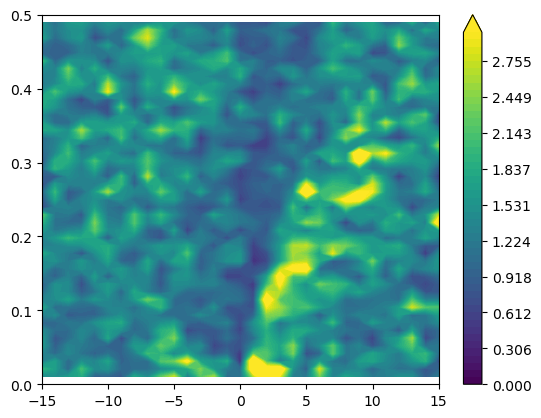

In [6]:
def background( data ):
    data = data.copy();

    kernel = np.array([ 1, 2, 1 ]) / 4.0;

    half_freq = data.shape[0]//2;

    for i in range( 10 ):
        data = convolve1d( data, kernel, axis=0, mode="reflect" );

    for i in range( 10 ):
        data[:half_freq] = convolve1d( data[:half_freq], kernel, axis=1, mode="reflect" );

    for i in range( 40 ):
        data[half_freq:] = convolve1d( data[half_freq:], kernel, axis=1, mode="reflect" );

    return data;

bg = background( (sym_ps + asy_ps)/2 );

plt.contourf( wn, fr[fr>0], sym_ps / bg, levels=np.linspace( 0, 3 ), extend="max" )
plt.xlim( -15, 15)
plt.ylim( 0, 0.5 )
plt.colorbar() 